# Import

In [16]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from collections import Counter
import warnings
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import itertools
from copy import deepcopy
import collections
from sklearn.model_selection import train_test_split
import json
import random
import re
import torch.optim as optim
from collections import defaultdict
import kagglehub

# Dataset

## Loading of the dataset

In [17]:
# Download latest version of the shakespeare dataset and save the path
path = kagglehub.dataset_download("kewagbln/shakespeareonline")
print("Path to dataset files:", path)
DATA_PATH = os.path.join(path, "t8.shakespeare.txt")
OUTPUT_DIR = "processed_data/"

Path to dataset files: /root/.cache/kagglehub/datasets/kewagbln/shakespeareonline/versions/1


## Paramters

In [18]:
TRAIN_FRACTION = 0.9  # percentage of the training data
SEQ_LEN = 80  # length of the sequence for the model
BATCH_SIZE = 4
N_VOCAB = 90  # Numero di caratteri nel vocabolario (ASCII)
EPOCHS = 200
LEARNING_RATE = 0.01
EMBEDDING_SIZE = 8
LSTM_HIDDEN_DIM = 256
SEQ_LENGTH = 80

# Dataset Parsing and Preprocessing
This section includes regular expressions and functions to parse Shakespeare's text into plays, characters, and their respective dialogues. The parsing handles special cases like "The Comedy of Errors" and prepares training and test datasets.

In [19]:
CHARACTER_RE = re.compile(r'^  ([a-zA-Z][a-zA-Z ]*)\. (.*)')  # Matches character lines
CONT_RE = re.compile(r'^    (.*)')  # Matches continuation lines
COE_CHARACTER_RE = re.compile(r'^([a-zA-Z][a-zA-Z ]*)\. (.*)')  # Special regex for Comedy of Errors
COE_CONT_RE = re.compile(r'^(.*)')  # Continuation for Comedy of Errors

def parse_shakespeare_file(filepath):
    """
    Reads and splits Shakespeare's text into plays, characters, and their dialogues.
    Returns training and test datasets based on the specified fraction.
    """
    with open(filepath, "r") as f:
        content = f.read()
    plays, _ = _split_into_plays(content)  # Split the text into plays
    _, train_examples, test_examples = _get_train_test_by_character(
        plays, test_fraction=1 - TRAIN_FRACTION
    )
    return train_examples, test_examples

def _split_into_plays(shakespeare_full):
    """
    Splits the full Shakespeare text into individual plays and characters' dialogues.
    Handles special parsing for "The Comedy of Errors".
    """
    plays = []
    slines = shakespeare_full.splitlines(True)[1:]  # Skip the first line (title/header)
    current_character = None
    comedy_of_errors = False

    for i, line in enumerate(slines):
        # Detect play titles and initialize character dictionary
        if "by William Shakespeare" in line:
            current_character = None
            characters = defaultdict(list)
            title = slines[i - 2].strip() if slines[i - 2].strip() else slines[i - 3].strip()
            comedy_of_errors = title == "THE COMEDY OF ERRORS"
            plays.append((title, characters))
            continue

        # Match character lines or continuation lines
        match = _match_character_regex(line, comedy_of_errors)
        if match:
            character, snippet = match.group(1).upper(), match.group(2)
            if not (comedy_of_errors and character.startswith("ACT ")):
                characters[character].append(snippet)
                current_character = character
        elif current_character:
            match = _match_continuation_regex(line, comedy_of_errors)
            if match:
                characters[current_character].append(match.group(1))

    # Filter out plays with insufficient dialogue data
    return [play for play in plays if len(play[1]) > 1], []

def _match_character_regex(line, comedy_of_errors=False):
    """Matches character dialogues, with special handling for 'The Comedy of Errors'."""
    return COE_CHARACTER_RE.match(line) if comedy_of_errors else CHARACTER_RE.match(line)

def _match_continuation_regex(line, comedy_of_errors=False):
    """Matches continuation lines of dialogues."""
    return COE_CONT_RE.match(line) if comedy_of_errors else CONT_RE.match(line)

def _get_train_test_by_character(plays, test_fraction=0.2):
    """
    Splits dialogues by characters into training and testing datasets.
    Ensures each character has at least one example in the training set.
    """
    all_train_examples = defaultdict(list)
    all_test_examples = defaultdict(list)

    def add_examples(example_dict, example_tuple_list):
        """Adds examples to the respective dataset dictionary."""
        for play, character, sound_bite in example_tuple_list:
            example_dict[f"{play}_{character}".replace(" ", "_")].append(sound_bite)

    for play, characters in plays:
        for character, sound_bites in characters.items():
            examples = [(play, character, sound_bite) for sound_bite in sound_bites]
            if len(examples) <= 2:
                continue

            # Calculate the number of test samples
            num_test = max(1, int(len(examples) * test_fraction))
            num_test = min(num_test, len(examples) - 1)  # Ensure at least one training example

            # Split into train and test sets
            train_examples = examples[:-num_test]
            test_examples = examples[-num_test:]

            add_examples(all_train_examples, train_examples)
            add_examples(all_test_examples, test_examples)

    return {}, all_train_examples, all_test_examples




# Text Processing
Functions to convert characters and words into numerical representations
for use in neural networks. Includes padding logic for batch processing.

In [20]:
def letter_to_vec(c, n_vocab=128):
    """Converts a single character to a vector index based on the vocabulary size."""
    return ord(c) % n_vocab

def word_to_indices(word, n_vocab=128):
    """
    Converts a word or list of words into a list of indices.
    Each character is mapped to an index based on the vocabulary size.
    """
    if isinstance(word, list):  # If input is a list of words
        res = []
        for stringa in word:
            res.extend([ord(c) % n_vocab for c in stringa])  # Convert each word to indices
        return res
    else:  # If input is a single word
        return [ord(c) % n_vocab for c in word]

def process_x(raw_x_batch, seq_len, n_vocab):
    """
    Processes raw input data into padded sequences of indices.
    Ensures all sequences are of uniform length.
    """
    x_batch = [word_to_indices(word, n_vocab) for word in raw_x_batch]
    x_batch = [x[:seq_len] + [0] * (seq_len - len(x)) for x in x_batch]
    return torch.tensor(x_batch, dtype=torch.long)


def process_y(raw_y_batch, seq_len, n_vocab):
    """
    Processes raw target data into padded sequences of indices.
    Shifts the sequence by one character to the right.
    y[1:seq_len + 1] takes the input data, right shift of an
    element and uses the next element of the sequence to fill
    and at the end (with [0]) final padding (zeros) are (eventually)
    added to reach the desired sequence length.
    """
    y_batch = [word_to_indices(word, n_vocab) for word in raw_y_batch]
    y_batch = [y[1:seq_len + 1] + [0] * (seq_len - len(y[1:seq_len + 1])) for y in y_batch]  # Shifting and final padding
    return torch.tensor(y_batch, dtype=torch.long)

def create_batches(data, batch_size, seq_len, n_vocab):
    """
    Creates batches of input and target data from dialogues.
    Each batch contains sequences of uniform length.
    """
    x_batches = []
    y_batches = []
    dialogues = list(data.values())
    random.shuffle(dialogues)  # Shuffle to ensure randomness in batches

    batch = []
    for dialogue in dialogues:
        batch.append(dialogue)
        if len(batch) == batch_size:
            x_batch = process_x(batch, seq_len, n_vocab)
            y_batch = process_y(batch, seq_len, n_vocab)
            x_batches.append(x_batch)
            y_batches.append(y_batch)
            batch = []

    # Add the last batch if it's not full
    if batch:
        x_batch = process_x(batch, seq_len, n_vocab)
        y_batch = process_y(batch, seq_len, n_vocab)
        x_batches.append(x_batch)
        y_batches.append(y_batch)

    return x_batches, y_batches



# Check pointing

In [21]:
import os
import torch
import json
from google.colab import drive
import shutil

# Monta Google Drive
drive.mount('/content/drive')

# Directory dove salvare i checkpoint
CHECKPOINT_DIR = './checkpoints/'
DRIVE_DIR = '/content/drive/MyDrive/checkpoints/'  # Percorso su Google Drive

# Assicurati che le directory esistano
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(DRIVE_DIR, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, hyperparameters, subfolder="", checkpoint_data=None):
    """
    Salva il checkpoint e lo copia su Google Drive.
    """
    subfolder_path = os.path.join(CHECKPOINT_DIR, subfolder)
    os.makedirs(subfolder_path, exist_ok=True)

    # Percorsi per i file
    filename = f"model_epoch_{epoch}_params_{hyperparameters}.pth"
    filepath = os.path.join(subfolder_path, filename)
    filename_json = f"model_epoch_{epoch}_params_{hyperparameters}.json"
    filepath_json = os.path.join(subfolder_path, filename_json)

    previous_filepath = os.path.join(subfolder_path, f"model_epoch_{epoch - 1}_params_{hyperparameters}.pth")
    previous_filepath_json = os.path.join(subfolder_path, f"model_epoch_{epoch - 1}_params_{hyperparameters}.json")

    # Rimuove il checkpoint precedente
    if epoch > 1 and os.path.exists(previous_filepath):
        os.remove(previous_filepath)
        os.remove(previous_filepath_json)

    checkpoint = {'model_state_dict': model.state_dict(), 'epoch': epoch}
    if optimizer is not None:
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()

    torch.save(checkpoint, filepath)
    print(f"Checkpoint salvato: {filepath}")

    if checkpoint_data:
        with open(filepath_json, 'w') as json_file:
            json.dump(checkpoint_data, json_file, indent=4)

    # Copia i file su Google Drive
    shutil.copy(filepath, DRIVE_DIR)
    if checkpoint_data:
        shutil.copy(filepath_json, DRIVE_DIR)
    print(f"Checkpoint copiato su Google Drive: {DRIVE_DIR}")



def load_checkpoint_from_drive(model, optimizer, hyperparameters, subfolder="", drive_dir='/content/drive/MyDrive/checkpoints/'):
    """
    Carica il checkpoint più recente da Google Drive.

    Arguments:
    model -- Il modello da aggiornare con i pesi caricati.
    optimizer -- L'ottimizzatore da aggiornare (può essere None).
    hyperparameters -- Stringa che identifica i parametri del modello per il nome del file.
    subfolder -- Sottocartella opzionale nella directory di Drive per cercare i checkpoint.
    drive_dir -- Percorso alla directory di Drive dove si trovano i checkpoint.

    Returns:
    Il numero di epoca successiva da cui riprendere e i dati JSON associati (se disponibili).
    """
    # Percorso della sottocartella su Google Drive
    subfolder_path = os.path.join(drive_dir, subfolder)

    # Controlla se la sottocartella esiste
    if not os.path.exists(subfolder_path):
        print("Checkpoint non trovato su Google Drive, inizio dall'epoca 1.")
        return 1, None

    # Cerca i file dei checkpoint che corrispondono agli hyperparameters
    files = [f for f in os.listdir(subfolder_path) if f"params_{hyperparameters}" in f and f.endswith('.pth')]

    # Se trovi file, carica quello con il numero di epoca più alto
    if files:
        latest_file = max(files, key=lambda x: int(x.split('_')[2]))  # Trova il file con l'epoca più alta
        filepath = os.path.join(subfolder_path, latest_file)
        checkpoint = torch.load(filepath)

        # Carica lo stato del modello
        model.load_state_dict(checkpoint['model_state_dict'])
        # Carica lo stato dell'optimizer (se disponibile)
        if optimizer:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Prova a caricare il file JSON associato
        json_filepath = filepath.replace('.pth', '.json')
        json_data = None
        if os.path.exists(json_filepath):
            with open(json_filepath, 'r') as json_file:
                json_data = json.load(json_file)
            print("Dati JSON caricati!")

        print(f"Checkpoint trovato: Ripresa dall'epoca {checkpoint['epoch'] + 1}.")
        return checkpoint['epoch'] + 1, json_data

    # Se non trovi file, inizia dall'epoca 1
    print("Checkpoint non trovato, inizio dall'epoca 1.")
    return 1, None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loader
This code defines a custom PyTorch Dataset class for processing Shakespeare dialogues.
The dataset converts raw text data into sequences of indices for training a character-level model.


In [22]:
from torch.utils.data import Dataset, DataLoader

class ShakespeareDataset(Dataset):
    """
    Custom PyTorch Dataset for processing Shakespeare dialogues.
    Converts input data into sequences of indices for input and target processing.
    """
    def __init__(self, data, seq_len, n_vocab):
        """
        Initializes the ShakespeareDataset instance.

        Args:
            data: Dictionary containing dialogues (e.g., train_data or test_data).
            seq_len: Length of sequences to generate for the model.
            n_vocab: Size of the vocabulary for mapping characters to indices.
        """
        self.data = list(data.values())  # Convert the dictionary values to a list
        self.seq_len = seq_len  # Sequence length for the model
        self.n_vocab = n_vocab  # Vocabulary size

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: Number of dialogues in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves a single sample (input and target) from the dataset.

        Args:
            idx: Index of the sample to retrieve.

        Returns:
            Tuple: Processed input (x) and target (y) tensors for the model.
        """
        dialogue = self.data[idx]  # Get the dialogue at the specified index
        x = process_x([dialogue], self.seq_len, self.n_vocab)[0]  # Prepare input tensor
        y = process_y([dialogue], self.seq_len, self.n_vocab)[0]  # Prepare target tensor
        return x, y

# Model Definition
CharLSTM is a character-based LSTM model designed for text generation.
It includes embedding, LSTM layers, and a fully connected layer for output.

In [23]:
import torch.nn.functional as F

class CharLSTM(nn.Module):
    """
    Character-level LSTM model for text processing tasks.
    Includes embedding, LSTM, and a fully connected output layer.
    We use:
    - embedding size equal to 8;
    - 2 LSTM layers, each with 256 nodes;
    - densely connected softmax output layer.

    We can avoid to use explicitly the softmax function in the model and
    keep a cross entropy loss function as a loss function.

    as mentioned in paper [2] (Sashank Reddi, Zachary Charles, Manzil Zaheer, Zachary Garrett, Keith Rush,
    Jakub Konečný, Sanjiv Kumar, H. Brendan McMahan; Adaptive Federated Optimization, 2021)
    """
    def __init__(self, vocab_size = 90, embedding_size = 8, lstm_hidden_dim = 256, seq_length=80):
        super(CharLSTM, self).__init__()
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.lstm_hidden_dim = lstm_hidden_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
        self.lstm1 = nn.LSTM(input_size=embedding_size, hidden_size=lstm_hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=lstm_hidden_dim, hidden_size=lstm_hidden_dim, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, x):
        """
        Forward pass through the model.
        """
        # Layer 1: Embedding
        x = self.embedding(x)  # Output shape: (batch_size, seq_length, embedding_dim)

        # Layer 2: First LSTM
        x, _ = self.lstm1(x)  # Output shape: (batch_size, seq_length, lstm_hidden_dim)

        # Layer 3: Second LSTM
        x, hidden = self.lstm2(x)  # Output shape: (batch_size, seq_length, lstm_hidden_dim)

        # Layer 4: Fully Connected Layer
        x = self.fc(x)  # Output shape: (batch_size, seq_length, vocab_size)

        # Softmax Activation
        #x = self.softmax(x)  # Output shape: (batch_size, seq_length, vocab_size)
        return x, hidden

    def init_hidden(self, batch_size):
        """Initializes hidden and cell states for the LSTM."""
        return (torch.zeros(2, batch_size),
            torch.zeros(2, batch_size))
        #2 is equal to the number of lstm layers!



# Training Loop
Trains the CharLSTM model using the prepared data and batches.

Utility function to evaluate the accuracy and loss of a on a validation/test set

## Data Loading

In [24]:
from torch.utils.data import random_split

train_data, test_data = parse_shakespeare_file(DATA_PATH)

train_dataset = ShakespeareDataset(train_data, seq_len=SEQ_LEN, n_vocab=N_VOCAB)
test_dataset = ShakespeareDataset(test_data, seq_len=SEQ_LEN, n_vocab=N_VOCAB)

# Split the train dataset into train and validation:
train_size = int(0.9 * len(train_dataset))  # 90%
valid_size = len(train_dataset) - train_size  # 10%
#random split:
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

# Creation of the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [25]:
from statistics import mean

def evaluate(model, dataloader, criterion, DEVICE):
    with torch.no_grad():
        model.train(False) # Set Network to evaluation mode
        running_corrects = 0
        total_predictions = 0  # Track total predictions for normalization
        losses = []
        for data, targets in dataloader:
            data = data.to(DEVICE)        # Move the data to the GPU
            targets = targets.to(DEVICE)  # Move the targets to the GPU
            # Forward Pass
            #state = model.init_hidden(data.size(0))
            # outputs is a tuple: (logits, hidden_state)
            outputs, _ = model(data) # unpack the tuple and get only the output (predictions)
            # Reshape the outputs for CrossEntropyLoss
            outputs = outputs.view(-1, model.vocab_size)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            losses.append(loss.item())
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            # Update Corrects (element-wise comparison for accuracy)
            running_corrects += (preds == targets).sum().item()
            total_predictions += targets.size(0)  # Update total prediction count

        # Calculate Accuracy (divide by total predictions)
        accuracy = (running_corrects / total_predictions) * 100

    return accuracy, mean(losses)

In [26]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

def train(num_epochs, model, optimizer, scheduler):
    print("Parsing dataset...")
    LOG_FREQUENCY = 10

    criterion = nn.CrossEntropyLoss()

    # We need to initialize best_val_acc to a very low value outside the epoch loop
    best_val_acc = 0.0

    # Training cycle
    val_accuracies = []
    val_losses = []
    train_accuracies = []
    train_losses = []

    for epoch in range(num_epochs):

        total_loss = 0
        correct = 0
        total = 0

        x_batches, y_batches = create_batches(train_data, BATCH_SIZE, SEQ_LEN, N_VOCAB)
        for x_batch, y_batch in zip(x_batches, y_batches):


            x_batch = x_batch.to(DEVICE)  # Move the data to the GPU
            y_batch = y_batch.to(DEVICE)  # Move the targets to the GPU

            model.train() # Set network to train mode
            optimizer.zero_grad() # Zero the gradients
            logits, _ = model(x_batch)  # Forward pass
            # Riformat logits and y_batch for CrossEntropyLoss
            logits = logits.view(-1, N_VOCAB)  # Reshape to (batch_size * seq_length, vocab_size)
            y_batch = y_batch.view(-1)  # Reshape to (batch_size * seq_length)
            loss = criterion(logits, y_batch)  # Calculate loss
            #Backpropagation
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # Compute the accuracy
            predictions = torch.argmax(logits, dim=1)  # Predictions for each class with argmax
            correct += (predictions == y_batch).sum().item()  # Sum of correct predictions
            total += y_batch.size(0)  #Total number of target

        # Evaluate on the validation set, done every epoch
        val_acc, val_loss = evaluate(model, val_loader, criterion, DEVICE)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        #print(f"Epoch {epoch + 1}/{EPOCHS}, Training Loss: {total_loss / len(train_loader):.4f}")
        # Compute the training accuracy
        accuracy = correct / total
        print(f"Training Accuracy: {accuracy:.2f}%")


        # Update the best model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = deepcopy(model.state_dict())  # Save the current model state
            print(f"New best model found with Validation accuracy: {val_acc:.2f}%")
        # Evaluate on the training set

        if(epoch%LOG_FREQUENCY==0):
            print(f"--> best validation accuracy: {best_val_acc:.2f} epoch: {epoch+1}")
            print(f"--> validation loss: {val_loss:.4f}-- training loss: {total_loss / len(train_loader):.4f}")

        scheduler.step()

        # if loss is zero exit
        if total_loss <= 0.00009:
          break
    return train_accuracies, train_losses, val_accuracies, val_losses, model

In [27]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = CharLSTM(vocab_size = N_VOCAB, embedding_size = EMBEDDING_SIZE, lstm_hidden_dim = LSTM_HIDDEN_DIM, seq_length = SEQ_LENGTH)
# model = model.to(DEVICE) # Move the entire model to the desired device

# # Definisci l'ottimizzatore Adam
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# # Definisci lo scheduler CosineAnnealingLR
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-4)

# train(200, model, optimizer, scheduler)

# Test

# Hyperparameters Tuning

In [28]:
def get_scheduler_factory(num_epochs):
    """
    Return a set of predefined learning rate scheduler factories with reasonable parameters.

    Args:
        num_epochs (int): Total number of epochs.

    Returns:
        list: List of tuples with scheduler names and factory functions.
    """
    schedulers = [
        # StepLR
        ("StepLR (step_size=num_epochs//3, gamma=0.1)",
         lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs // 3, gamma=0.1)),

        # CosineAnnealingLR
        ("CosineAnnealingLR",
         lambda optimizer: torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)),

        # ExponentialLR
        ("ExponentialLR (gamma=0.9)",
         lambda optimizer: torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)),
    ]
    return schedulers


In this section we will perform the hyperparameters selection using grid search among the considered values of paper [2] (Sashank Reddi, Zachary Charles, Manzil Zaheer, Zachary Garrett, Keith Rush,
    Jakub Konečný, Sanjiv Kumar, H. Brendan McMahan; Adaptive Federated Optimization, 2021)

In [29]:
# Generate 3 values for the learning rate (lr) between 1e-3 and 1e-1 in log-uniform
learning_rates = np.logspace(-3, -1, num=3)
# Generate 4 values for the weight decay (lr) between 1e-4 and 1e-1 in log-uniform
weight_decays = np.logspace(-4, -1, num=4)

In [33]:
num_epochs = 20  # low value for parameter tuning

scheduler_factories = get_scheduler_factory(num_epochs)
results = []
best_validation_accuracy_overall = 0.0
best_setting = None
print('Starting the parameter tuning loop...')
for lr in learning_rates:
    for wd in weight_decays:
        for scheduler_name, scheduler_factory in scheduler_factories:
            # Reset the model
            model = CharLSTM(vocab_size = N_VOCAB, embedding_size = EMBEDDING_SIZE, lstm_hidden_dim = LSTM_HIDDEN_DIM, seq_length = SEQ_LENGTH)
            model = model.to(DEVICE) # Move the entire model to the desired device

            # Create the optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

            # Definisci lo scheduler CosineAnnealingLR
            #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-4)
            #optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
            # Create the scheduler
            scheduler = scheduler_factory(optimizer)
            # Ezecute training
            train_accuracies, train_losses, val_accuracies, val_losses, model = train(num_epochs, model, optimizer, scheduler)
            # Print the best validation accuracy
            best_val_accuracy = max(val_accuracies)
            if best_val_accuracy > best_validation_accuracy_overall:
                best_validation_accuracy_overall = best_val_accuracy
                best_setting = (lr, wd)
                best_wd = wd
                best_lr = lr
                best_scheduler = scheduler
            print(f'Learning Rate: {lr}, Weight Decay: {wd}, Scheduler: {scheduler_name}, Best Validation Accuracy: {best_val_accuracy:.2f}%')

            results.append({
                'learning_rate': lr,
                'weight_decay': wd,
                'scheduler_name': scheduler_name,
                'train_accuracies': train_accuracies,
                'train_losses': train_losses,
                'val_accuracies': val_accuracies,
                'val_losses': val_losses,
            })
print("Finished training loop.")
print(f'Best validation accuracy overall: {best_validation_accuracy_overall*100:.2f}%')
print(f'Best setting: {best_setting}')

Starting the parameter tuning loop...
Parsing dataset...
Training Accuracy: 0.21%
New best model found with Validation accuracy: 28.48%
--> best validation accuracy: 28.48 epoch: 1
--> validation loss: 2.6770-- training loss: 3.3738
Training Accuracy: 0.30%
New best model found with Validation accuracy: 31.53%
Training Accuracy: 0.35%
New best model found with Validation accuracy: 36.42%
Training Accuracy: 0.39%
New best model found with Validation accuracy: 40.04%
Training Accuracy: 0.41%
New best model found with Validation accuracy: 41.71%
Training Accuracy: 0.43%
New best model found with Validation accuracy: 43.53%
Training Accuracy: 0.45%
New best model found with Validation accuracy: 45.20%
Training Accuracy: 0.46%
New best model found with Validation accuracy: 45.32%
Training Accuracy: 0.46%
New best model found with Validation accuracy: 45.67%
Training Accuracy: 0.46%
New best model found with Validation accuracy: 46.07%
Training Accuracy: 0.47%
New best model found with Valid

## Plot the tuning results

In [38]:
import matplotlib.pyplot as plt
import os
import re  # Imported module for regular expressions

def plot_results(results, save_dir='./plots_centralized_2'):
    """
    Save plots comparing training and validation metrics per epoch for all hyperparameter combinations.

    Args:
        results (list): List of dictionaries, where each dictionary contains:
                        - 'learning_rate': Learning rate used.
                        - 'weight_decay': Weight decay used.
                        - 'scheduler_name': Name of the scheduler.
                        - 'train_accuracies': List of training accuracies.
                        - 'val_accuracies': List of validation accuracies.
                        - 'train_losses': List of training losses.
                        - 'val_losses': List of validation losses.
        save_dir (str): Directory where the plots will be saved.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Create figures for training and validation loss
    fig_loss_train, ax_loss_train = plt.subplots(figsize=(12, 6))
    fig_loss_val, ax_loss_val = plt.subplots(figsize=(12, 6))

    for res in results:
        # Extract hyperparameter values
        lr = res['learning_rate']
        wd = res['weight_decay']
        scheduler_name = res['scheduler_name']

        # Create a label for the legend
        label = f"LR={lr}, WD={wd}, Scheduler={scheduler_name}"

        # Plot training loss
        ax_loss_train.plot(res['train_losses'], label=label)

        # Plot validation loss
        ax_loss_val.plot(res['val_losses'], label=label)

    # Set labels and titles for training loss plot
    ax_loss_train.set_xlabel('Epoch')
    ax_loss_train.set_ylabel('Loss')
    ax_loss_train.set_title("Training Loss for Different Hyperparameter Configurations")
    ax_loss_train.legend()

    # Set labels and titles for validation loss plot
    ax_loss_val.set_xlabel('Epoch')
    ax_loss_val.set_ylabel('Loss')
    ax_loss_val.set_title("Validation Loss for Different Hyperparameter Configurations")
    ax_loss_val.legend()

    # Save the plots
    fig_loss_train.savefig(os.path.join(save_dir, "training_loss_comparison.png"))
    fig_loss_val.savefig(os.path.join(save_dir, "validation_loss_comparison.png"))

    print(f"Plots saved to directory: {save_dir}")

In [ ]:
import matplotlib.pyplot as plt
import os
import re  # Imported module for regular expressions

def plot_results(results, save_dir='./plots_centralized'):
    """
    Save plots comparing training and validation metrics per epoch for all hyperparameter combinations.

    Args:
        results (list): List of dictionaries, where each dictionary contains:
                        - 'learning_rate': Learning rate used.
                        - 'weight_decay': Weight decay used.
                        - 'scheduler_name': Name of the scheduler.
                        - 'train_accuracies': List of training accuracies.
                        - 'val_accuracies': List of validation accuracies.
                        - 'train_losses': List of training losses.
                        - 'val_losses': List of validation losses.
        save_dir (str): Directory where the plots will be saved.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Create figures for training and validation loss
    fig_loss_train, ax_loss_train = plt.subplots(figsize=(12, 6))
    fig_loss_val, ax_loss_val = plt.subplots(figsize=(12, 6))

    for res in results:
        # Extract hyperparameter values
        lr = res['learning_rate']
        wd = res['weight_decay']
        scheduler_name = res['scheduler_name']

        # Create a label for the legend
        label = f"LR={lr}, WD={wd}, Scheduler={scheduler_name}"

        # Plot training loss
        ax_loss_train.plot(res['train_losses'], label=label)

        # Plot validation loss
        ax_loss_val.plot(res['val_losses'], label=label)

    # Set labels and titles for training loss plot
    ax_loss_train.set_xlabel('Epoch')
    ax_loss_train.set_ylabel('Loss')
    ax_loss_train.set_title("Training Loss for Different Hyperparameter Configurations")
    ax_loss_train.legend()

    # Set labels and titles for validation loss plot
    ax_loss_val.set_xlabel('Epoch')
    ax_loss_val.set_ylabel('Loss')
    ax_loss_val.set_title("Validation Loss for Different Hyperparameter Configurations")
    ax_loss_val.legend()

    # Save the plots
    fig_loss_train.savefig(os.path.join(save_dir, "training_loss_comparison.png"))
    fig_loss_val.savefig(os.path.join(save_dir, "validation_loss_comparison.png"))

    print(f"Plots saved to directory: {save_dir}")

Plots saved to directory: ./plots_centralized_2


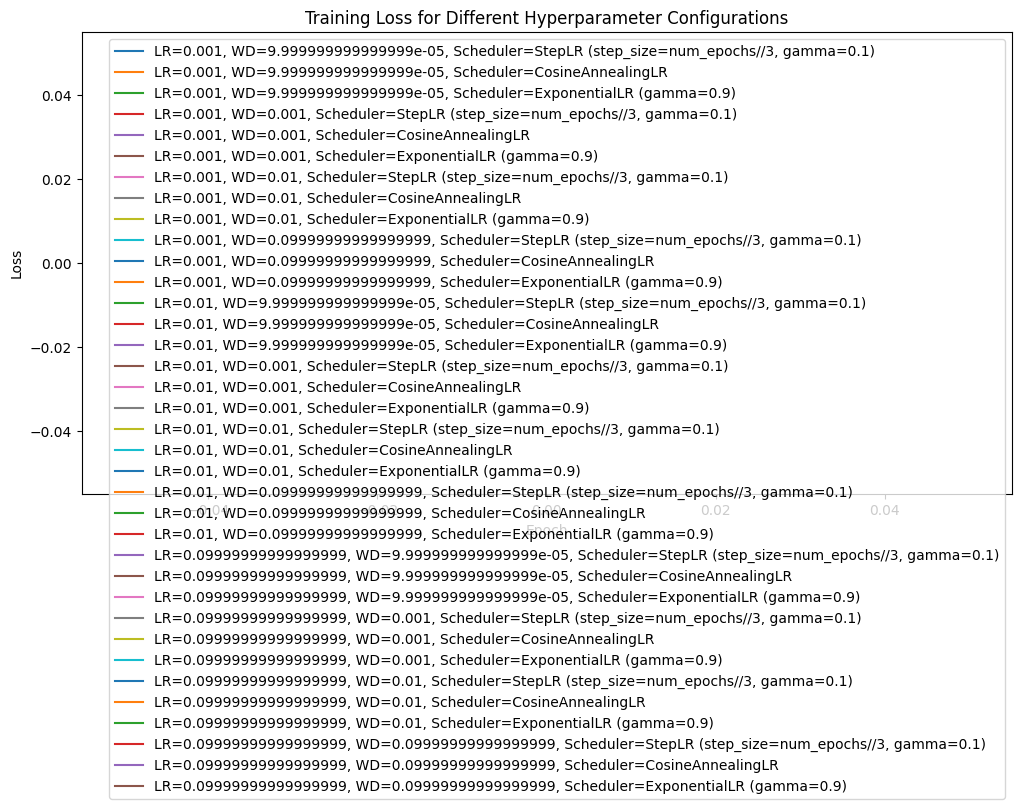

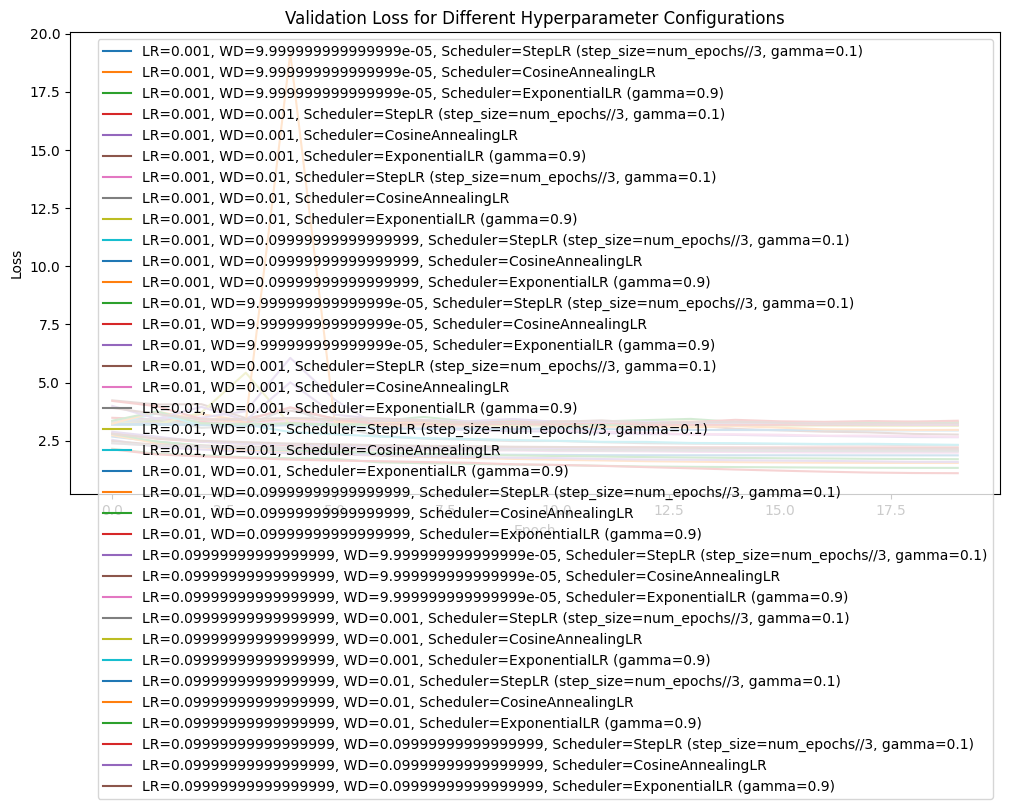

In [39]:
plot_results(results)

# Train the best model

In [ ]:
model = CharLSTM(vocab_size = N_VOCAB, embedding_size = EMBEDDING_SIZE, lstm_hidden_dim = LSTM_HIDDEN_DIM, seq_length = SEQ_LENGTH)
model = model.to(DEVICE) # Move the entire model to the desired device
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_wd)
scheduler = best_scheduler
num_epochs = 200
train_accuracies, train_losses, val_accuracies, val_losses, model = train(num_epochs, model, optimizer, scheduler)

# Test

In [41]:
def test(model, testloader):
    """
    Test the model on the test set.
    """
    accuracy, loss = evaluate(model, testloader, nn.CrossEntropyLoss(), DEVICE)
    return accuracy, loss

# Plotting the results

In [ ]:
import matplotlib.pyplot as plt
import os
import re  # Imported module for regular expressions

def plot_results(results, save_dir='./plots_centralized'):
    """
    Save plots comparing training accuracy and validation accuracy per epoch for each combination of hyperparameters.

    Args:
        results (list): List of dictionaries, where each dictionary contains:
                        - 'learning_rate': Learning rate used.
                        - 'weight_decay': Weight decay used.
                        - 'scheduler_name': Name of the scheduler.
                        - 'train_accuracies': List of training accuracies.
                        - 'val_accuracies': List of validation accuracies.
        save_dir (str): Directory where the plots will be saved.
    """
    os.makedirs(save_dir, exist_ok=True)

    for res in results:
        # Extract hyperparameter values
        lr = res['learning_rate']
        wd = res['weight_decay']
        scheduler_name = res['scheduler_name']

        # Clean up the scheduler name for filename compatibility
        clean_scheduler_name = re.sub(r"[^a-zA-Z0-9]", "_", scheduler_name)  # Sostituisce i caratteri non alfanumerici con '_'

        # Generate a unique filename prefix for each configuration
        file_prefix = f"LR_{lr}_WD_{wd}_Scheduler_{clean_scheduler_name}"

        # Plot training and validation accuracy per epoch
        plt.figure(figsize=(12, 6))
        plt.plot(res['train_accuracies'], label='Training Accuracy')
        plt.plot(res['val_accuracies'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f"Training vs Validation Accuracy (LR={lr}, WD={wd}, Scheduler={scheduler_name})")
        plt.legend()
        accuracy_plot_path = os.path.join(save_dir, f"{file_prefix}_training_vs_validation_accuracy.png")
        plt.savefig(accuracy_plot_path)
        plt.close()

    print(f"Plots saved to directory: {save_dir}")

#Plot only the best result
filtered_results = [res for res in results if res['learning_rate'] == 0.01 and res['weight_decay'] == 0.0001 and res['scheduler_name']=="CosineAnnealingLR (T_max=num_epochs//3, eta_min=1e-4)"]
plot_results(filtered_results)

# Test

In [43]:
test(model, test_loader)

(18.24205326460481, 3.432136330817573)